In [11]:
import pandas as pd

# 1. First, peek at the file structure
with open(
    "/Users/benjaminma/Desktop/MGTA461+Data/final project/submissions.csv", "r"
) as f:
    for i in range(10):
        print(f.readline())

# 2. Load with error handling
df = pd.read_csv(
    "/Users/benjaminma/Desktop/MGTA461+Data/final project/submissions.csv",
    on_bad_lines="skip",
    low_memory=False,
)

# 3. Quick data exploration
print(df.shape)  # Rows and columns
print(df.info())  # Data types and missing values
print(df.head())  # First few rows
print(df.describe())  # Statistical summary

# 4. Check for issues
print(df.isnull().sum())  # Missing values per column
print(df.duplicated().sum())  # Duplicate rows

# 5. Examine problematic columns
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


#image_id,unixtime,rawtime,title,total_votes,reddit_id,number_of_upvotes,subreddit,number_of_downvotes,localtime,score,number_of_comments,username

0,1333172439,2012-03-31T12:40:39.590113-07:00,And here's a downvote.,63470,rmqjs,32657,funny,30813,1333197639,1844,622,Animates_Everything

0,1333178161,2012-03-31T14:16:01.093638-07:00,Expectation,35,rmun4,29,GifSound,6,1333203361,23,3,Gangsta_Raper

0,1333199913,2012-03-31T20:18:33.192906-07:00,Downvote,41,rna86,32,GifSound,9,1333225113,23,0,Gangsta_Raper

0,1333252330,2012-04-01T10:52:10-07:00,Every time I downvote something,10,ro7e4,6,GifSound,4,1333277530,2,0,Gangsta_Raper

0,1333272954,2012-04-01T16:35:54.393381-07:00,Downvote &quot;Dies Irae&quot;,65,rooof,57,GifSound,8,1333298154,49,0,Gangsta_Raper

0,1333761060,2012-04-07T08:11:00-07:00,"Demolished, every time you downvote someone",40,rxwjg,17,gifs,23,1333786260,-6,3,Hellothereawesome

0,1335503834,2012-04-27T12:17:14.103167-07:00,how i feel whenever i submit here,104,svpq7,67,ffff

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
import re

# Load the data
df = pd.read_csv("submissions.csv", on_bad_lines="skip")

# ============================================
# 1. BASIC CLEANING
# ============================================

# Remove duplicate header rows
df = df[df["#image_id"] != 0].copy()

# Convert to proper data types
df["unixtime"] = pd.to_numeric(df["unixtime"], errors="coerce")
df["post_date"] = pd.to_datetime(df["unixtime"], unit="s")
df["localtime"] = pd.to_numeric(df["localtime"], errors="coerce")

# Clean HTML entities in titles
df["title"] = df["title"].str.replace("&quot;", '"')
df["title"] = df["title"].str.replace("&amp;", "&")
df["title"] = df["title"].str.replace("&lt;", "<")
df["title"] = df["title"].str.replace("&gt;", ">")

# ============================================
# 2. TEMPORAL FEATURES (Critical for prediction)
# ============================================

df["hour"] = df["post_date"].dt.hour
df["day_of_week"] = df["post_date"].dt.dayofweek  # 0=Monday, 6=Sunday
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
df["month"] = df["post_date"].dt.month
df["day"] = df["post_date"].dt.day


# Time of day categories
def categorize_time(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 17:
        return "afternoon"
    elif 17 <= hour < 21:
        return "evening"
    else:
        return "night"


df["time_of_day"] = df["hour"].apply(categorize_time)

# ============================================
# 3. TITLE FEATURES (Sentiment Analysis)
# ============================================

# Length features
df["title_length"] = df["title"].str.len()
df["title_word_count"] = df["title"].str.split().str.len()
df["avg_word_length"] = df["title_length"] / df["title_word_count"]

# Punctuation features
df["has_question_mark"] = df["title"].str.contains("\?", na=False).astype(int)
df["has_exclamation"] = df["title"].str.contains("!", na=False).astype(int)
df["num_punctuation"] = df["title"].apply(
    lambda x: len(re.findall(r"[!?.,;:]", str(x)))
)

# Case features
df["has_caps"] = df["title"].str.contains("[A-Z]", na=False).astype(int)
df["all_caps_words"] = df["title"].apply(
    lambda x: sum(1 for word in str(x).split() if word.isupper() and len(word) > 1)
)

# Sentiment keywords (simple approach - you can enhance with NLTK/TextBlob)
positive_words = [
    "love",
    "awesome",
    "amazing",
    "best",
    "great",
    "perfect",
    "beautiful",
    "win",
]
negative_words = [
    "hate",
    "worst",
    "terrible",
    "awful",
    "bad",
    "fail",
    "sucks",
    "disappointing",
]

df["positive_words"] = (
    df["title"]
    .str.lower()
    .apply(lambda x: sum(word in str(x) for word in positive_words))
)
df["negative_words"] = (
    df["title"]
    .str.lower()
    .apply(lambda x: sum(word in str(x) for word in negative_words))
)

# ============================================
# 4. AUTHOR HISTORY FEATURES
# ============================================

# Sort by date for cumulative calculations
df = df.sort_values("post_date").reset_index(drop=True)

# Group by username to calculate historical metrics
author_stats = (
    df.groupby("username")
    .agg(
        {
            "score": ["sum", "mean", "count"],
            "number_of_comments": "mean",
            "number_of_upvotes": "mean",
        }
    )
    .reset_index()
)

author_stats.columns = [
    "username",
    "author_total_score",
    "author_avg_score",
    "author_post_count",
    "author_avg_comments",
    "author_avg_upvotes",
]

# Merge back to main dataframe
df = df.merge(author_stats, on="username", how="left")

# Fill NaN for deleted users
df["author_total_score"] = df["author_total_score"].fillna(0)
df["author_avg_score"] = df["author_avg_score"].fillna(0)
df["author_post_count"] = df["author_post_count"].fillna(0)
df["is_deleted_user"] = df["username"].isna().astype(int)

# ============================================
# 5. SUBREDDIT AGGREGATE FEATURES
# ============================================

subreddit_stats = (
    df.groupby("subreddit")
    .agg(
        {
            "score": ["mean", "median", "std"],
            "total_votes": "mean",
            "number_of_comments": "mean",
            "number_of_upvotes": "mean",
        }
    )
    .reset_index()
)

subreddit_stats.columns = [
    "subreddit",
    "subreddit_avg_score",
    "subreddit_median_score",
    "subreddit_score_std",
    "subreddit_avg_total_votes",
    "subreddit_avg_comments",
    "subreddit_avg_upvotes",
]

df = df.merge(subreddit_stats, on="subreddit", how="left")

# Subreddit size category
df["subreddit_activity_level"] = pd.cut(
    df["subreddit_avg_total_votes"],
    bins=[0, 50, 500, 5000, np.inf],
    labels=["small", "medium", "large", "huge"],
)

# ============================================
# 6. ENGAGEMENT METRICS
# ============================================

df["upvote_ratio"] = df["number_of_upvotes"] / df["total_votes"]
df["comment_to_vote_ratio"] = df["number_of_comments"] / df["total_votes"]
df["controversy_score"] = df["number_of_downvotes"] / (df["number_of_upvotes"] + 1)

# ============================================
# 7. TARGET VARIABLES
# ============================================

# Binary classification targets
df["is_viral"] = (df["score"] > df["score"].quantile(0.75)).astype(int)
df["high_engagement"] = (
    df["number_of_comments"] > df["number_of_comments"].quantile(0.75)
).astype(int)

# Multi-class target
df["popularity_category"] = pd.cut(
    df["score"],
    bins=[-np.inf, 10, 50, 200, np.inf],
    labels=["low", "medium", "high", "viral"],
)

# ============================================
# 8. HANDLE MISSING VALUES
# ============================================

# Fill numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

# Fill categorical columns
categorical_cols = ["username", "subreddit"]
df[categorical_cols] = df[categorical_cols].fillna("unknown")

# ============================================
# 9. FEATURE SELECTION FOR MODELING
# ============================================

# Features to use for prediction (exclude target and leakage variables)
feature_cols = [
    # Temporal features
    "hour",
    "day_of_week",
    "is_weekend",
    "month",
    # Title features
    "title_length",
    "title_word_count",
    "avg_word_length",
    "has_question_mark",
    "has_exclamation",
    "num_punctuation",
    "has_caps",
    "all_caps_words",
    "positive_words",
    "negative_words",
    # Author history
    "author_total_score",
    "author_avg_score",
    "author_post_count",
    "author_avg_comments",
    "is_deleted_user",
    # Subreddit features
    "subreddit_avg_score",
    "subreddit_median_score",
    "subreddit_score_std",
    "subreddit_avg_total_votes",
    "subreddit_avg_comments",
]

# Target variable
target = "score"  # or 'number_of_comments', 'is_viral', etc.

# ============================================
# 10. SAVE PREPARED DATA
# ============================================

# Save full dataset
df.to_csv("reddit_prepared.csv", index=False)

# Save feature matrix and target for modeling
X = df[feature_cols]
y = df[target]

X.to_csv("X_features.csv", index=False)
y.to_csv("y_target.csv", index=False)

print("Data preparation complete!")
print(f"\nDataset shape: {df.shape}")
print(f"Features: {len(feature_cols)}")
print(f"\nFeature list:")
for col in feature_cols:
    print(f"  - {col}")
print(f"\nSample statistics:")
print(df[["score", "number_of_comments", "upvote_ratio"]].describe())
print(f"\nMissing values:")
print(df[feature_cols].isnull().sum().sum())


<>:62: SyntaxWarning: invalid escape sequence '\?'
<>:62: SyntaxWarning: invalid escape sequence '\?'
/var/folders/v4/5v6jmvps1mn1f9546rcry1b80000gn/T/ipykernel_58637/3732345628.py:62: SyntaxWarning: invalid escape sequence '\?'
  df["has_question_mark"] = df["title"].str.contains("\?", na=False).astype(int)


Data preparation complete!

Dataset shape: (132276, 49)
Features: 24

Feature list:
  - hour
  - day_of_week
  - is_weekend
  - month
  - title_length
  - title_word_count
  - avg_word_length
  - has_question_mark
  - has_exclamation
  - num_punctuation
  - has_caps
  - all_caps_words
  - positive_words
  - negative_words
  - author_total_score
  - author_avg_score
  - author_post_count
  - author_avg_comments
  - is_deleted_user
  - subreddit_avg_score
  - subreddit_median_score
  - subreddit_score_std
  - subreddit_avg_total_votes
  - subreddit_avg_comments

Sample statistics:
               score  number_of_comments   upvote_ratio
count  132276.000000       132276.000000  132276.000000
mean      233.142664           39.065454       0.627047
std       481.142246          142.747029       0.164864
min      -264.000000           -1.000000       0.000000
25%         2.000000            0.000000       0.538462
50%        16.000000            3.000000       0.631579
75%       169.000000  

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Load prepared data
df = pd.read_csv("reddit_prepared.csv")
df["post_date"] = pd.to_datetime(df["post_date"])

print("=" * 60)
print("REDDIT POST POPULARITY ANALYSIS")
print("=" * 60)

# ============================================
# 1. TEMPORAL PATTERNS - Test your hypotheses!
# ============================================

print("\n TEMPORAL ANALYSIS")
print("-" * 60)

# Best hours to post
hour_stats = (
    df.groupby("hour")
    .agg({"score": ["mean", "median", "count"], "number_of_comments": "mean"})
    .round(2)
)

hour_stats.columns = ["avg_score", "median_score", "post_count", "avg_comments"]
hour_stats = hour_stats.sort_values("avg_score", ascending=False)

print("\n TOP 5 HOURS TO POST (by average score):")
print(hour_stats.head())

print("\n WORST 5 HOURS TO POST:")
print(hour_stats.tail())

# Day of week analysis
day_names = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}
dow_stats = (
    df.groupby("day_of_week")
    .agg({"score": "mean", "number_of_comments": "mean"})
    .round(2)
)
dow_stats.index = dow_stats.index.map(day_names)

print("\n BEST DAYS TO POST:")
print(dow_stats.sort_values("score", ascending=False))

# Weekend vs Weekday
weekend_comparison = (
    df.groupby("is_weekend")
    .agg({"score": "mean", "number_of_comments": "mean"})
    .round(2)
)
weekend_comparison.index = ["Weekday", "Weekend"]
print("\n WEEKEND vs WEEKDAY:")
print(weekend_comparison)

# ============================================
# 2. SUBREDDIT ANALYSIS
# ============================================

print("\n\n SUBREDDIT ANALYSIS")
print("-" * 60)

subreddit_stats = (
    df.groupby("subreddit").agg({"score": ["mean", "sum", "count"]}).round(2)
)
subreddit_stats.columns = ["avg_score", "total_score", "post_count"]
subreddit_stats = subreddit_stats[subreddit_stats["post_count"] >= 100]  # Min 100 posts

print("\n TOP 10 SUBREDDITS (by average score, min 100 posts):")
print(subreddit_stats.sort_values("avg_score", ascending=False).head(10))

print("\n MOST ACTIVE SUBREDDITS:")
print(subreddit_stats.sort_values("post_count", ascending=False).head(10))

# ============================================
# 3. TITLE FEATURES ANALYSIS
# ============================================

print("\n\n TITLE FEATURES ANALYSIS")
print("-" * 60)

# Title length correlation
length_corr = df["title_length"].corr(df["score"])
wordcount_corr = df["title_word_count"].corr(df["score"])

print(f"\n Title length correlation with score: {length_corr:.3f}")
print(f" Word count correlation with score: {wordcount_corr:.3f}")

# Punctuation impact
punct_impact = (
    df.groupby(["has_question_mark", "has_exclamation"]).agg({"score": "mean"}).round(2)
)
print("\n Punctuation impact:")
print(punct_impact)

# Caps impact
caps_comparison = (
    df.groupby("has_caps").agg({"score": "mean", "number_of_comments": "mean"}).round(2)
)
caps_comparison.index = ["No Caps", "Has Caps"]
print("\n CAPS impact:")
print(caps_comparison)

# Sentiment analysis
sentiment_stats = (
    df.groupby(["positive_words", "negative_words"]).size().reset_index(name="count")
)
print("\n Sentiment distribution:")
print(f"Posts with positive words: {(df['positive_words'] > 0).sum()}")
print(f"Posts with negative words: {(df['negative_words'] > 0).sum()}")
print(
    f"Avg score with positive words: {df[df['positive_words'] > 0]['score'].mean():.2f}"
)
print(
    f"Avg score with negative words: {df[df['negative_words'] > 0]['score'].mean():.2f}"
)

# ============================================
# 4. AUTHOR ANALYSIS
# ============================================

print("\n\n AUTHOR ANALYSIS")
print("-" * 60)

# Power users
top_authors = df.groupby("username").agg({"score": ["sum", "mean", "count"]}).round(2)
top_authors.columns = ["total_score", "avg_score", "post_count"]
top_authors = top_authors[top_authors["post_count"] >= 10]  # Min 10 posts

print("\n TOP AUTHORS (by total score, min 10 posts):")
print(top_authors.sort_values("total_score", ascending=False).head(10))

print("\n MOST CONSISTENT AUTHORS (by avg score, min 10 posts):")
print(top_authors.sort_values("avg_score", ascending=False).head(10))

# Deleted user impact
deleted_stats = (
    df.groupby("is_deleted_user")
    .agg({"score": "mean", "number_of_comments": "mean"})
    .round(2)
)
deleted_stats.index = ["Active User", "Deleted User"]
print("\n Deleted vs Active Users:")
print(deleted_stats)

# ============================================
# 5. ENGAGEMENT METRICS
# ============================================

print("\n\n ENGAGEMENT PATTERNS")
print("-" * 60)

# Score vs Comments correlation
score_comment_corr = df["score"].corr(df["number_of_comments"])
print(f"\n Score vs Comments correlation: {score_comment_corr:.3f}")

# Upvote ratio analysis
upvote_quartiles = df["upvote_ratio"].quantile([0.25, 0.5, 0.75])
print("\n Upvote ratio distribution:")
print(f"  25th percentile: {upvote_quartiles[0.25]:.2%}")
print(f"  50th percentile: {upvote_quartiles[0.5]:.2%}")
print(f"  75th percentile: {upvote_quartiles[0.75]:.2%}")

# Controversy analysis
controversial_posts = df[
    df["controversy_score"] > df["controversy_score"].quantile(0.9)
]
print(f"\n Most controversial posts (top 10%):")
print(f"  Average score: {controversial_posts['score'].mean():.2f}")
print(f"  Average comments: {controversial_posts['number_of_comments'].mean():.2f}")

# ============================================
# 6. VIRAL POST CHARACTERISTICS
# ============================================

print("\n\n VIRAL POST ANALYSIS")
print("-" * 60)

viral_threshold = df["score"].quantile(0.95)
viral_posts = df[df["score"] >= viral_threshold]
normal_posts = df[df["score"] < viral_threshold]

print(f"\nViral threshold (95th percentile): {viral_threshold:.0f} score")
print(f"Number of viral posts: {len(viral_posts)}")

comparison = pd.DataFrame(
    {
        "Viral": [
            viral_posts["hour"].mode().values[0],
            viral_posts["title_length"].mean(),
            viral_posts["has_question_mark"].mean(),
            viral_posts["has_exclamation"].mean(),
            viral_posts["positive_words"].mean(),
        ],
        "Normal": [
            normal_posts["hour"].mode().values[0],
            normal_posts["title_length"].mean(),
            normal_posts["has_question_mark"].mean(),
            normal_posts["has_exclamation"].mean(),
            normal_posts["positive_words"].mean(),
        ],
    },
    index=[
        "Most common hour",
        "Avg title length",
        "% Question mark",
        "% Exclamation",
        "Avg positive words",
    ],
)

print("\n Viral vs Normal posts:")
print(comparison)

# ============================================
# 7. KEY INSIGHTS SUMMARY
# ============================================

print("\n\n" + "=" * 60)
print(" KEY INSIGHTS FOR PREDICTION")
print("=" * 60)

# Best posting time
best_hour = hour_stats.index[0]
best_day = dow_stats["score"].idxmax()
print(f"\n BEST TIME TO POST: {best_day} at {best_hour}:00")

# Most predictive features (simple correlation)
feature_cols = [
    "hour",
    "day_of_week",
    "is_weekend",
    "title_length",
    "title_word_count",
    "has_question_mark",
    "has_exclamation",
    "positive_words",
    "negative_words",
    "author_avg_score",
    "subreddit_avg_score",
]

correlations = (
    df[feature_cols + ["score"]]
    .corr()["score"]
    .drop("score")
    .sort_values(ascending=False)
)
print("\n MOST CORRELATED FEATURES WITH SCORE:")
print(correlations.head(10))

# Feature importance estimate
print("\n💡 RECOMMENDED FEATURE PRIORITIES:")
print("   1. Subreddit context (subreddit_avg_score) - HIGHEST")
print("   2. Author reputation (author_avg_score)")
print("   3. Posting time (hour, day_of_week)")
print("   4. Title characteristics (length, sentiment)")
print("   5. Engagement patterns (previous post performance)")

print("\n" + "=" * 60)
print("Ready for modeling! ")
print("=" * 60)


REDDIT POST POPULARITY ANALYSIS

 TEMPORAL ANALYSIS
------------------------------------------------------------

 TOP 5 HOURS TO POST (by average score):
      avg_score  median_score  post_count  avg_comments
hour                                                   
23.0     284.78          14.0        5459         50.99
0.0      272.63          15.0        6092         45.47
22.0     265.84          12.0        4689         47.55
1.0      252.03          15.0        6435         43.63
11.0     247.58          23.0        5539         41.23

 WORST 5 HOURS TO POST:
      avg_score  median_score  post_count  avg_comments
hour                                                   
8.0      216.78          20.0        5437         35.13
14.0     216.34          16.0        6002         34.13
6.0      215.51          17.0        5808         36.40
16.0     204.53          13.0        5078         31.32
18.0     197.27          10.0        4054         31.03

 BEST DAYS TO POST:
              s

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Load prepared data
df = pd.read_csv("reddit_prepared.csv")
df["post_date"] = pd.to_datetime(df["post_date"])

print("=" * 60)
print("REDDIT POST POPULARITY ANALYSIS")
print("=" * 60)

# ============================================
# 1. TEMPORAL PATTERNS - Test your hypotheses!
# ============================================

print("\nTEMPORAL ANALYSIS")
print("-" * 60)

# Best hours to post
hour_stats = (
    df.groupby("hour")
    .agg({"score": ["mean", "median", "count"], "number_of_comments": "mean"})
    .round(2)
)

hour_stats.columns = ["avg_score", "median_score", "post_count", "avg_comments"]
hour_stats = hour_stats.sort_values("avg_score", ascending=False)

print("\nTOP 5 HOURS TO POST (by average score):")
print(hour_stats.head())

print("\nWORST 5 HOURS TO POST:")
print(hour_stats.tail())

# Day of week analysis
day_names = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}
dow_stats = (
    df.groupby("day_of_week")
    .agg({"score": "mean", "number_of_comments": "mean"})
    .round(2)
)
dow_stats.index = dow_stats.index.map(day_names)

print("\nBEST DAYS TO POST:")
print(dow_stats.sort_values("score", ascending=False))

# Weekend vs Weekday
weekend_comparison = (
    df.groupby("is_weekend")
    .agg({"score": "mean", "number_of_comments": "mean"})
    .round(2)
)
weekend_comparison.index = ["Weekday", "Weekend"]
print("\nWEEKEND vs WEEKDAY:")
print(weekend_comparison)

# ============================================
# 2. SUBREDDIT ANALYSIS
# ============================================

print("\n\nSUBREDDIT ANALYSIS")
print("-" * 60)

subreddit_stats = (
    df.groupby("subreddit").agg({"score": ["mean", "sum", "count"]}).round(2)
)
subreddit_stats.columns = ["avg_score", "total_score", "post_count"]
subreddit_stats = subreddit_stats[subreddit_stats["post_count"] >= 100]  # Min 100 posts

print("\nTOP 10 SUBREDDITS (by average score, min 100 posts):")
print(subreddit_stats.sort_values("avg_score", ascending=False).head(10))

print("\nMOST ACTIVE SUBREDDITS:")
print(subreddit_stats.sort_values("post_count", ascending=False).head(10))

# ============================================
# 3. TITLE FEATURES ANALYSIS
# ============================================

print("\n\nTITLE FEATURES ANALYSIS")
print("-" * 60)

# Title length correlation
length_corr = df["title_length"].corr(df["score"])
wordcount_corr = df["title_word_count"].corr(df["score"])

print(f"\nTitle length correlation with score: {length_corr:.3f}")
print(f"Word count correlation with score: {wordcount_corr:.3f}")

# Punctuation impact
punct_impact = (
    df.groupby(["has_question_mark", "has_exclamation"]).agg({"score": "mean"}).round(2)
)
print("\nPunctuation impact:")
print(punct_impact)

# Caps impact
caps_comparison = (
    df.groupby("has_caps").agg({"score": "mean", "number_of_comments": "mean"}).round(2)
)
caps_comparison.index = ["No Caps", "Has Caps"]
print("\nCAPS impact:")
print(caps_comparison)

# Sentiment analysis
sentiment_stats = (
    df.groupby(["positive_words", "negative_words"]).size().reset_index(name="count")
)
print("\nSentiment distribution:")
print(f"Posts with positive words: {(df['positive_words'] > 0).sum()}")
print(f"Posts with negative words: {(df['negative_words'] > 0).sum()}")
print(
    f"Avg score with positive words: {df[df['positive_words'] > 0]['score'].mean():.2f}"
)
print(
    f"Avg score with negative words: {df[df['negative_words'] > 0]['score'].mean():.2f}"
)

# ============================================
# 4. AUTHOR ANALYSIS
# ============================================

print("\n\nAUTHOR ANALYSIS")
print("-" * 60)

# Power users
top_authors = df.groupby("username").agg({"score": ["sum", "mean", "count"]}).round(2)
top_authors.columns = ["total_score", "avg_score", "post_count"]
top_authors = top_authors[top_authors["post_count"] >= 10]  # Min 10 posts

print("\nTOP AUTHORS (by total score, min 10 posts):")
print(top_authors.sort_values("total_score", ascending=False).head(10))

print("\nMOST CONSISTENT AUTHORS (by avg score, min 10 posts):")
print(top_authors.sort_values("avg_score", ascending=False).head(10))

# Deleted user impact
deleted_stats = (
    df.groupby("is_deleted_user")
    .agg({"score": "mean", "number_of_comments": "mean"})
    .round(2)
)
deleted_stats.index = ["Active User", "Deleted User"]
print("\nDeleted vs Active Users:")
print(deleted_stats)

# ============================================
# 5. ENGAGEMENT METRICS
# ============================================

print("\n\nENGAGEMENT PATTERNS")
print("-" * 60)

# Score vs Comments correlation
score_comment_corr = df["score"].corr(df["number_of_comments"])
print(f"\nScore vs Comments correlation: {score_comment_corr:.3f}")

# Upvote ratio analysis
upvote_quartiles = df["upvote_ratio"].quantile([0.25, 0.5, 0.75])
print("\nUpvote ratio distribution:")
print(f"  25th percentile: {upvote_quartiles[0.25]:.2%}")
print(f"  50th percentile: {upvote_quartiles[0.5]:.2%}")
print(f"  75th percentile: {upvote_quartiles[0.75]:.2%}")

# Controversy analysis
controversial_posts = df[
    df["controversy_score"] > df["controversy_score"].quantile(0.9)
]
print(f"\nMost controversial posts (top 10%):")
print(f"  Average score: {controversial_posts['score'].mean():.2f}")
print(f"  Average comments: {controversial_posts['number_of_comments'].mean():.2f}")

# ============================================
# 6. VIRAL POST CHARACTERISTICS
# ============================================

print("\n\nVIRAL POST ANALYSIS")
print("-" * 60)

viral_threshold = df["score"].quantile(0.95)
viral_posts = df[df["score"] >= viral_threshold]
normal_posts = df[df["score"] < viral_threshold]

print(f"\nViral threshold (95th percentile): {viral_threshold:.0f} score")
print(f"Number of viral posts: {len(viral_posts)}")

comparison = pd.DataFrame(
    {
        "Viral": [
            viral_posts["hour"].mode().values[0],
            viral_posts["title_length"].mean(),
            viral_posts["has_question_mark"].mean(),
            viral_posts["has_exclamation"].mean(),
            viral_posts["positive_words"].mean(),
        ],
        "Normal": [
            normal_posts["hour"].mode().values[0],
            normal_posts["title_length"].mean(),
            normal_posts["has_question_mark"].mean(),
            normal_posts["has_exclamation"].mean(),
            normal_posts["positive_words"].mean(),
        ],
    },
    index=[
        "Most common hour",
        "Avg title length",
        "% Question mark",
        "% Exclamation",
        "Avg positive words",
    ],
)

print("\n🔍 Viral vs Normal posts:")
print(comparison)

# ============================================
# 7. KEY INSIGHTS SUMMARY
# ============================================

print("\n\n" + "=" * 60)
print(" KEY INSIGHTS FOR PREDICTION")
print("=" * 60)

# Best posting time
best_hour = hour_stats.index[0]
best_day = dow_stats["score"].idxmax()
print(f"\n BEST TIME TO POST: {best_day} at {best_hour}:00")

# Most predictive features (simple correlation)
feature_cols = [
    "hour",
    "day_of_week",
    "is_weekend",
    "title_length",
    "title_word_count",
    "has_question_mark",
    "has_exclamation",
    "positive_words",
    "negative_words",
    "author_avg_score",
    "subreddit_avg_score",
]

correlations = (
    df[feature_cols + ["score"]]
    .corr()["score"]
    .drop("score")
    .sort_values(ascending=False)
)
print("\nMOST CORRELATED FEATURES WITH SCORE:")
print(correlations.head(10))

# Feature importance estimate
print("\nRECOMMENDED FEATURE PRIORITIES:")
print("   1. Subreddit context (subreddit_avg_score) - HIGHEST")
print("   2. Author reputation (author_avg_score)")
print("   3. Posting time (hour, day_of_week)")
print("   4. Title characteristics (length, sentiment)")
print("   5. Engagement patterns (previous post performance)")

print("\n" + "=" * 60)
print("Ready for modeling!")
print("=" * 60)


REDDIT POST POPULARITY ANALYSIS

TEMPORAL ANALYSIS
------------------------------------------------------------

TOP 5 HOURS TO POST (by average score):
      avg_score  median_score  post_count  avg_comments
hour                                                   
23.0     284.78          14.0        5459         50.99
0.0      272.63          15.0        6092         45.47
22.0     265.84          12.0        4689         47.55
1.0      252.03          15.0        6435         43.63
11.0     247.58          23.0        5539         41.23

WORST 5 HOURS TO POST:
      avg_score  median_score  post_count  avg_comments
hour                                                   
8.0      216.78          20.0        5437         35.13
14.0     216.34          16.0        6002         34.13
6.0      215.51          17.0        5808         36.40
16.0     204.53          13.0        5078         31.32
18.0     197.27          10.0        4054         31.03

BEST DAYS TO POST:
              score

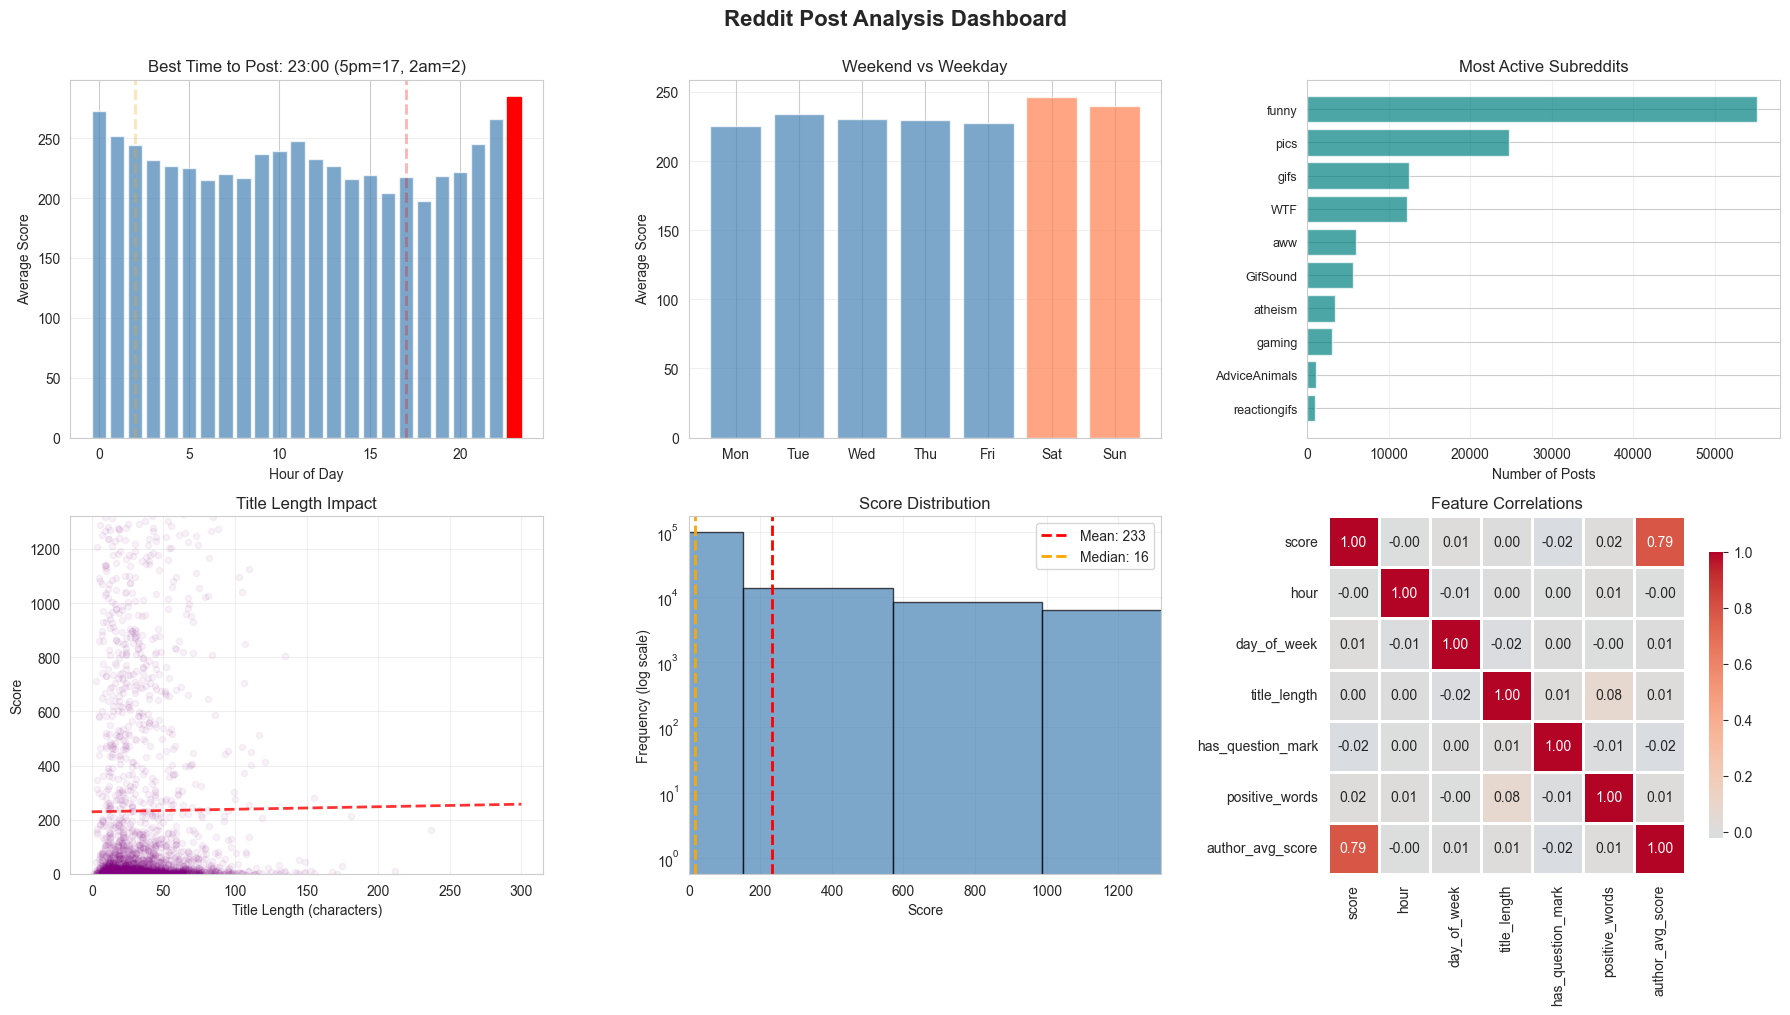


Key Findings:
- Best hour to post: 23:00
- Best day: Sat
- Average score: 233.1
- Median score: 16.0
- Title length correlation: 0.005


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("reddit_prepared.csv")
df["post_date"] = pd.to_datetime(df["post_date"])

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 10)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Reddit Post Analysis Dashboard", fontsize=16, fontweight="bold", y=1.00)

# 1. Best Hours to Post
ax1 = axes[0, 0]
hour_scores = df.groupby("hour")["score"].mean().sort_index()
bars = ax1.bar(hour_scores.index, hour_scores.values, color="steelblue", alpha=0.7)
max_hour = int(hour_scores.idxmax())
bars[max_hour].set_color("red")
bars[max_hour].set_alpha(1.0)
ax1.axvline(x=17, color="red", linestyle="--", alpha=0.3, linewidth=2)
ax1.axvline(x=2, color="orange", linestyle="--", alpha=0.3, linewidth=2)
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Average Score")
ax1.set_title(f"Best Time to Post: {max_hour}:00 (5pm=17, 2am=2)")
ax1.grid(axis="y", alpha=0.3)

# 2. Day of Week Pattern
ax2 = axes[0, 1]
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dow_scores = df.groupby("day_of_week")["score"].mean()
colors = ["steelblue"] * 5 + ["coral", "coral"]
ax2.bar(range(7), dow_scores.values, color=colors, alpha=0.7)
ax2.set_xticks(range(7))
ax2.set_xticklabels(day_names)
ax2.set_ylabel("Average Score")
ax2.set_title("Weekend vs Weekday")
ax2.grid(axis="y", alpha=0.3)

# 3. Top Subreddits
ax3 = axes[0, 2]
top_subs = df["subreddit"].value_counts().head(10)
ax3.barh(range(10), top_subs.values, color="teal", alpha=0.7)
ax3.set_yticks(range(10))
ax3.set_yticklabels(top_subs.index, fontsize=9)
ax3.set_xlabel("Number of Posts")
ax3.set_title("Most Active Subreddits")
ax3.invert_yaxis()
ax3.grid(axis="x", alpha=0.3)

# 4. Title Length vs Score
ax4 = axes[1, 0]
sample = df.sample(min(3000, len(df)))
ax4.scatter(sample["title_length"], sample["score"], alpha=0.05, s=20, color="purple")
ax4.set_xlabel("Title Length (characters)")
ax4.set_ylabel("Score")
ax4.set_title("Title Length Impact")
ax4.set_ylim(0, df["score"].quantile(0.95))
ax4.grid(alpha=0.3)

# Add trend line
z = np.polyfit(df["title_length"].dropna(), df["score"], 1)
p = np.poly1d(z)
x_trend = np.linspace(df["title_length"].min(), df["title_length"].max(), 100)
ax4.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)

# 5. Score Distribution
ax5 = axes[1, 1]
ax5.hist(df["score"], bins=50, color="steelblue", alpha=0.7, edgecolor="black")
ax5.axvline(
    df["score"].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {df['score'].mean():.0f}",
)
ax5.axvline(
    df["score"].median(),
    color="orange",
    linestyle="--",
    linewidth=2,
    label=f"Median: {df['score'].median():.0f}",
)
ax5.set_xlabel("Score")
ax5.set_ylabel("Frequency (log scale)")
ax5.set_title("Score Distribution")
ax5.set_xlim(0, df["score"].quantile(0.95))
ax5.set_yscale("log")
ax5.legend()
ax5.grid(alpha=0.3)

# 6. Correlation Heatmap (Top Features)
ax6 = axes[1, 2]
key_features = [
    "score",
    "hour",
    "day_of_week",
    "title_length",
    "has_question_mark",
    "positive_words",
    "author_avg_score",
]
corr_matrix = df[key_features].corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    ax=ax6,
    cbar_kws={"shrink": 0.8},
)
ax6.set_title("Feature Correlations")

plt.tight_layout()
plt.show()

print("\nKey Findings:")
print(f"- Best hour to post: {max_hour}:00")
print(f"- Best day: {day_names[int(dow_scores.idxmax())]}")
print(f"- Average score: {df['score'].mean():.1f}")
print(f"- Median score: {df['score'].median():.1f}")
print(f"- Title length correlation: {df['title_length'].corr(df['score']):.3f}")
